Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Train net

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import json
from tensorflow.keras.utils import to_categorical

# Read the JSON file to get the image and mask correspondence
def get_image_mask_pairs_from_json(json_path, img_dir, mask_dir):
    image_files = []
    mask_files = []

    with open(json_path, 'r') as f:
        data = json.load(f)
        for item in data['images']:
            file_name = item['file_name']
            image_path = os.path.join(img_dir, os.path.relpath(file_name, 'images'))
            mask_name = f"{os.path.splitext(os.path.basename(file_name))[0]}_mask_v2.png"
            mask_path = os.path.join(mask_dir, os.path.dirname(os.path.relpath(file_name, 'images')), mask_name)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

    return image_files, mask_files

# Preprocess the mask image and convert it to a unique thermal encoding format
def preprocess_mask(mask, num_classes=3):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    mask = np.clip(mask, 0, num_classes - 1)  # Make sure the class is in the range [0, num_classes-1]
    mask = to_categorical(mask, num_classes=num_classes)
    return mask

# Custom data generator
def data_generator(img_dir, mask_dir, json_path, batch_size, target_size=(256, 256), num_classes=3):
    image_files, mask_files = get_image_mask_pairs_from_json(json_path, img_dir, mask_dir)
    data_size = len(image_files)

    if data_size == 0:
        raise ValueError("No valid image-mask pairs found. Please check the file paths or naming conventions.")

    while True:
        indices = np.random.permutation(data_size)
        for i in range(0, data_size, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_images = []
            batch_masks = []

            for idx in batch_indices:
                img = cv2.imread(image_files[idx])
                img = cv2.resize(img, target_size)
                img = img / 255.0  # Normalization

                mask = cv2.imread(mask_files[idx])
                mask = cv2.resize(mask, target_size)
                mask = preprocess_mask(mask, num_classes)  # Convert labels to one-hot encoding

                batch_images.append(img)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

# Set the path on Google Drive
train_img_dir = '/content/drive/MyDrive/zx/images'
train_mask_dir = '/content/drive/MyDrive/zx/masks_train_v2'
valid_mask_dir = '/content/drive/MyDrive/zx/masks_valid_v2'
train_json_path = '/content/drive/MyDrive/zx/train_annotations_v2.json'
valid_json_path = '/content/drive/MyDrive/zx/valid_annotations_v2.json'

# Set up the data generator
batch_size = 8
train_generator = data_generator(train_img_dir, train_mask_dir, train_json_path, batch_size)
valid_generator = data_generator(train_img_dir, valid_mask_dir, valid_json_path, batch_size)

# Define U-Net model
def unet_model(input_size=(256, 256, 3), num_classes=3):
    inputs = Input(input_size)

    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create and compile the model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train
epochs = 20
steps_per_epoch = 100
validation_steps = 50

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=validation_steps
)

print("Training completed.")
# Save model
model.save('/content/drive/MyDrive/zx/trained_model.h5')
print("Model saved successfully.")



Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 704ms/step - accuracy: 0.8455 - loss: 0.7048 - val_accuracy: 0.8748 - val_loss: 0.2956
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 692ms/step - accuracy: 0.8693 - loss: 0.2884 - val_accuracy: 0.8974 - val_loss: 0.2418
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 692ms/step - accuracy: 0.8961 - loss: 0.2507 - val_accuracy: 0.9160 - val_loss: 0.1892
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.9230 - loss: 0.1890 - val_accuracy: 0.9306 - val_loss: 0.1735
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 656ms/step - accuracy: 0.9222 - loss: 0.1914 - val_accuracy: 0.9382 - val_loss: 0.1620
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.9200 - loss: 0.2008 - val_accuracy: 0.9425 - val_loss: 0.1486
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.9314 - loss: 0.1766 - val_accuracy: 0.9412 - val_loss: 0.1498
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 664ms/step - accuracy: 0.9307 - loss: 0

Training completed.
Model saved successfully.


Testing net and Calculating IoU

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json

# Preprocess mask images and convert them to one-hot encoded format
def preprocess_mask(mask, num_classes=3):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    mask = np.clip(mask, 0, num_classes - 1)   # Make sure the class is in the range [0, num_classes-1]
    mask = tf.keras.utils.to_categorical(mask, num_classes=num_classes)
    return mask

# Load test data
def load_test_data(json_path, img_dir, mask_dir, target_size=(256, 256), num_classes=3):
    image_files = []
    mask_files = []

    with open(json_path, 'r') as f:
        data = json.load(f)
        for item in data['images']:
            file_name = item['file_name']
            image_path = os.path.join(img_dir, os.path.relpath(file_name, 'images'))
            mask_name = f"{os.path.splitext(os.path.basename(file_name))[0]}_mask_v2.png"
            mask_path = os.path.join(mask_dir, os.path.dirname(os.path.relpath(file_name, 'images')), mask_name)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image at path: {img_path}")
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalization
        images.append(img)




        mask = cv2.imread(mask_path)
        if mask is None:
            print(f"Failed to read mask at path: {mask_path}")
        mask = cv2.resize(mask, target_size)
        mask = preprocess_mask(mask, num_classes)  # Convert labels to one-hot encoding
        masks.append(mask)

    return np.array(images), np.array(masks)



# Calculate the IoU
def compute_iou(y_true, y_pred, num_classes=3):
    iou = []
    for i in range(num_classes):
        intersection = np.logical_and(y_true == i, y_pred == i).sum()
        union = np.logical_or(y_true == i, y_pred == i).sum()
        iou.append(intersection / union if union != 0 else 0)
    return np.mean(iou)

# Load model
model_path = '/content/drive/MyDrive/zx/trained_model.h5'
model = load_model(model_path)

# Load test data
test_img_dir = '/content/drive/MyDrive/zx/images'
test_mask_dir = '/content/drive/MyDrive/zx/masks_test_v2'
test_json_path = '/content/drive/MyDrive/zx/test_annotations_v2.json'
X_test, Y_test = load_test_data(test_json_path, test_img_dir, test_mask_dir)

# Model prediction and IoU calculation
iou_scores = []
for img, mask in zip(X_test, Y_test):
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)
    true_mask = np.argmax(mask, axis=-1)

    iou = compute_iou(true_mask, pred_mask)
    iou_scores.append(iou)

# Output average IoU
mean_iou = np.mean(iou_scores)
print(f"Mean IoU on test set: {mean_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━

Calculate the IoU for 3 categories:

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import json

# Load the trained model
model_path = '/content/drive/MyDrive/zx/trained_model.h5'
model = load_model(model_path)

# Define function to load and preprocess test data
def load_test_data(json_path, img_dir, mask_dir, target_size=(256, 256), num_classes=3):
    image_files = []
    mask_files = []

    with open(json_path, 'r') as f:
        data = json.load(f)
        for item in data['images']:
            file_name = item['file_name']
            image_path = os.path.join(img_dir, os.path.relpath(file_name, 'images'))
            mask_name = f"{os.path.splitext(os.path.basename(file_name))[0]}_mask_v2.png"
            mask_path = os.path.join(mask_dir, os.path.dirname(os.path.relpath(file_name, 'images')), mask_name)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

    images = []
    masks = []
    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        images.append(img)

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, target_size)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = np.clip(mask, 0, num_classes - 1)
        mask = to_categorical(mask, num_classes=num_classes)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Function to calculate IoU for each class
def compute_iou(y_true, y_pred, num_classes):
    ious = []
    for i in range(num_classes):
        intersection = np.logical_and(y_true == i, y_pred == i).sum()
        union = np.logical_or(y_true == i, y_pred == i).sum()
        if union == 0:
            ious.append(np.nan)  # Handle division by zero
        else:
            ious.append(intersection / union)
    return ious

# Load test data
test_img_dir = '/content/drive/MyDrive/zx/images'
test_mask_dir = '/content/drive/MyDrive/zx/masks_test_v2'
test_json_path = '/content/drive/MyDrive/zx/test_annotations_v2.json'
test_images, test_masks = load_test_data(test_json_path, test_img_dir, test_mask_dir)

# Run predictions and calculate IoU
all_ious = {0: [], 1: [], 2: []}  # Separate IoUs for head, flippers, and carapace

for img, true_mask in zip(test_images, test_masks):
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred_mask, axis=-1)  # Get the predicted class
    true_mask = np.argmax(true_mask, axis=-1)  # Get the true class

    ious = compute_iou(true_mask, pred_mask, num_classes=3)
    for i in range(3):
        if not np.isnan(ious[i]):
            all_ious[i].append(ious[i])

# Calculate mean IoU for each class
mean_ious = {class_id: np.nanmean(iou_list) for class_id, iou_list in all_ious.items()}
print("Mean IoU for Head:", mean_ious[0])
print("Mean IoU for Flippers:", mean_ious[1])
print("Mean IoU for Carapace:", mean_ious[2])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━

Calculate the IoU for 4 categories:

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import json

# Load test data
def load_test_data(json_path, img_dir, mask_dir, target_size=(256, 256), num_classes=4):
    image_files = []
    mask_files = []

    with open(json_path, 'r') as f:
        data = json.load(f)
        for item in data['images']:
            file_name = item['file_name']
            image_path = os.path.join(img_dir, os.path.relpath(file_name, 'images'))
            mask_name = f"{os.path.splitext(os.path.basename(file_name))[0]}_mask_v2.png"
            mask_path = os.path.join(mask_dir, os.path.dirname(os.path.relpath(file_name, 'images')), mask_name)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        images.append(img)

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, target_size)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        mask = np.clip(mask, 0, num_classes - 1)  # Make sure the class is in the range [0, num_classes-1]
        masks.append(mask)

    return np.array(images), np.array(masks)

# Calculate the IoU
def calculate_iou_per_class(true_masks, pred_masks, num_classes=4):
    iou_scores = []
    class_names = ["Background", "Head", "Flippers", "Carapace"]

    for i in range(num_classes):
        intersection = np.logical_and(pred_masks == i, true_masks == i).sum()
        union = np.logical_or(pred_masks == i, true_masks == i).sum()
        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)
        print(f"Mean IoU for {class_names[i]}: {iou}")

    return iou_scores

# Load model
model_path = '/content/drive/MyDrive/zx/trained_model.h5'
model = load_model(model_path, compile=False)

# Set the test data path
test_img_dir = '/content/drive/MyDrive/zx/images'
test_mask_dir = '/content/drive/MyDrive/zx/masks_test_v2'
test_json_path = '/content/drive/MyDrive/zx/test_annotations_v2.json'

# Load test data
test_images, test_masks = load_test_data(test_json_path, test_img_dir, test_mask_dir)

# Run predictions and calculate IoU
pred_masks = model.predict(test_images)
pred_masks = np.argmax(pred_masks, axis=-1)  # Preprocess mask images and convert them to one-hot encoded format

iou_scores = calculate_iou_per_class(test_masks, pred_masks, num_classes=4)
print("Mean IoU scores:", iou_scores)


37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step
Mean IoU for Background: 0.9486267092723748
Mean IoU for Head: 0.0
Mean IoU for Flippers: 6.801514693149456e-05
Mean IoU for Carapace: 0.0
Mean IoU scores: [0.9486267092723748, 0.0, 6.801514693149456e-05, 0.0]


Calculate the evaluation index of the model：


37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step
Mean IoU for Background: 0.9486266954995164
Mean IoU for Head: 0.0
Mean IoU for Flippers: 6.801515639174171e-05
Mean IoU for Carapace: 0.0
Mean IoU scores: [0.9486266954995164, 0.0, 6.801515639174171e-05, 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 0.8467577213245766, Average Precision (AP): 0.8302505449670788, Average Recall (AR): 0.863941067013005


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


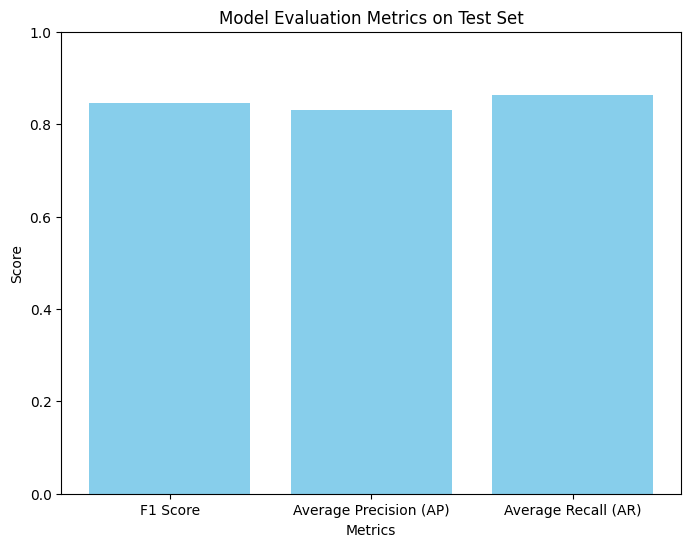

F1 Score: 0.8467577213245766, Average Precision (AP): 0.8302505449670788, Average Recall (AR): 0.863941067013005


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import json
from sklearn.metrics import f1_score, precision_score, recall_score

# Load test data
def load_test_data(json_path, img_dir, mask_dir, target_size=(256, 256), num_classes=4):
    image_files = []
    mask_files = []

    with open(json_path, 'r') as f:
        data = json.load(f)
        for item in data['images']:
            file_name = item['file_name']
            image_path = os.path.join(img_dir, os.path.relpath(file_name, 'images'))
            mask_name = f"{os.path.splitext(os.path.basename(file_name))[0]}_mask_v2.png"
            mask_path = os.path.join(mask_dir, os.path.dirname(os.path.relpath(file_name, 'images')), mask_name)

            if os.path.exists(image_path) and os.path.exists(mask_path):
                image_files.append(image_path)
                mask_files.append(mask_path)

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        images.append(img)

        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, target_size)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        mask = np.clip(mask, 0, num_classes - 1)  # Make sure the class is in the range [0, num_classes-1]
        masks.append(mask)

    return np.array(images), np.array(masks)

# Calculate the IoU
def calculate_iou_per_class(true_masks, pred_masks, num_classes=4):
    iou_scores = []
    class_names = ["Background", "Head", "Flippers", "Carapace"]

    for i in range(num_classes):
        intersection = np.logical_and(pred_masks == i, true_masks == i).sum()
        union = np.logical_or(pred_masks == i, true_masks == i).sum()
        iou = intersection / union if union != 0 else 0
        iou_scores.append(iou)
        print(f"Mean IoU for {class_names[i]}: {iou}")

    return iou_scores

# Load model
model_path = '/content/drive/MyDrive/zx/trained_model.h5'
model = load_model(model_path, compile=False)

# Set the test data path
test_img_dir = '/content/drive/MyDrive/zx/images'
test_mask_dir = '/content/drive/MyDrive/zx/masks_test_v2'
test_json_path = '/content/drive/MyDrive/zx/test_annotations_v2.json'

# Load test data
test_images, test_masks = load_test_data(test_json_path, test_img_dir, test_mask_dir)

# Run predictions and calculate IoU
pred_masks = model.predict(test_images)
pred_masks = np.argmax(pred_masks, axis=-1)  # Preprocess mask images and convert them to one-hot encoded format

# Calculate the IoU
iou_scores = calculate_iou_per_class(test_masks, pred_masks, num_classes=4)
print("Mean IoU scores:", iou_scores)

# Flattened to calculate F1 Score, AP and AR
flat_true_masks = test_masks.flatten()
flat_pred_masks = pred_masks.flatten()

# calculate F1 Score, AP and AR
f1 = f1_score(flat_true_masks, flat_pred_masks, average="weighted")
ap = precision_score(flat_true_masks, flat_pred_masks, average="weighted")
ar = recall_score(flat_true_masks, flat_pred_masks, average="weighted")

print(f"F1 Score: {f1}, Average Precision (AP): {ap}, Average Recall (AR): {ar}")

import matplotlib.pyplot as plt

# calculate F1 Score, AP and AR
f1 = f1_score(flat_true_masks, flat_pred_masks, average="weighted")
ap = precision_score(flat_true_masks, flat_pred_masks, average="weighted")
ar = recall_score(flat_true_masks, flat_pred_masks, average="weighted")

# Plot the result as a bar chart
metrics = ['F1 Score', 'Average Precision (AP)', 'Average Recall (AR)']
scores = [f1, ap, ar]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color='skyblue')
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics on Test Set')
plt.show()

print(f"F1 Score: {f1}, Average Precision (AP): {ap}, Average Recall (AR): {ar}")

